<a href="https://colab.research.google.com/github/Eddietrantkt/CF_Quan22280073_Tuong22280102/blob/main/FINANCE_week4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance pandas matplotlib mplfinance prophet scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 7.7 MB/s eta 0:00:00


# Import Python Libraries and set defalut value

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
start_time = "2021-01-01"
end_time = datetime.now()
ngan_hang_vn = ["VCB.VN", "TCB.VN", "ACB.VN", "MBB.VN", "BID.VN", "CTG.VN", "HDB.VN", "TPB.VN", "MSB.VN", "SHB.VN"]

# Download price-volume data

In [ ]:
data = yf.download(ngan_hang_vn, start=start_time, end=end_time, auto_adjust=False)
data.tail(3)

[*********************100%***********************]  10 of 10 completed


Price      Adj Close                                                        \
Ticker        ACB.VN   BID.VN   CTG.VN   HDB.VN   MBB.VN   MSB.VN   SHB.VN   
Date                                                                         
2025-10-29   25400.0  37800.0  49650.0  33400.0  24350.0  12550.0  16800.0   
2025-10-30   25100.0  37900.0  49200.0  33400.0  23950.0  12350.0  16900.0   
2025-10-31   25500.0  37400.0  49000.0  32000.0  23600.0  12050.0  16450.0   

Price                                       ...    Volume                      \
Ticker       TCB.VN        TPB.VN   VCB.VN  ...    ACB.VN   BID.VN     CTG.VN   
Date                                        ...                                 
2025-10-29  36400.0  17285.714844  60700.0  ...  36658230  3207848  7481263.0   
2025-10-30  35700.0  17150.000000  60600.0  ...   9720545  2602763  4884057.0   
2025-10-31  35100.0  16650.000000  59600.0  ...  16827430  2378179  9974477.0   

Price                                                                        \
Ticker        HDB.VN    MBB.VN    MSB.VN       SHB.VN      TCB.VN    TPB.VN   
Date                                                                          
2025-10-29  34754610  28514760  10878080  118173800.0  13774450.0  11699005   
2025-10-30  23793070  27235650   4419336   71866010.0  10679850.0   5644447   
2025-10-31  24986310  20228190  10067250   46967260.0  12815550.0   8961570   

Price                
Ticker       VCB.VN  
Date                 
2025-10-29  4465810  
2025-10-30  1951674  
2025-10-31  2394883  

[3 rows x 60 columns]

# Convert to DataFrame

In [ ]:
# Giả sử DataFrame ban đầu của bạn có tên là 'data'

# 1. Stack cấp độ 'Ticker' (level 1) từ cột xuống thành index
data_stacked = data.stack(level='Ticker')

# 2. Chuyển tất cả các cấp index (Date và Ticker) thành các cột
data_long = data_stacked.reset_index()

# 3. --- ĐÂY LÀ DÒNG BẠN CẦN ---
# Xóa tên 'Price' (tên của trục cột)
data_long = data_long.rename_axis(None, axis=1)

# 4. Đổi tên cột 'Adj Close' thành 'Adjust Close'
# (Giả sử cột ngày tháng của bạn tên là 'Date' sau khi reset)
data_long = data_long.rename(columns={
    'Adj Close': 'Adjust Close',
    'Date': 'Date' # Đảm bảo tên cột ngày tháng là 'Date'
})

# 5. Sắp xếp lại các cột theo đúng thứ tự bạn mong muốn
desired_columns = ['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Adjust Close', 'Volume']

# Lọc các cột này để đảm bảo chúng tồn tại
final_columns = [col for col in desired_columns if col in data_long.columns]
data_final = data_long[final_columns]
# Đổi tên cột Ticker thành Ngan_hang_VN
data_final = data_final.rename(columns={'Ticker': 'Ngan_hang_VN'})
# Chuyển cột Date dùng làm Index
data_final = data_final.set_index('Date')

/tmp/ipython-input-3058485067.py:4: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data_stacked = data.stack(level='Ticker')


# Vẽ BoxPlot xác định ngoại lai

In [ ]:
data = data_final

/tmp/ipython-input-637596147.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data[data['Ngan_hang_VN'] == ticker]['Close'] for ticker in ngan_hang_vn], labels=ngan_hang_vn)


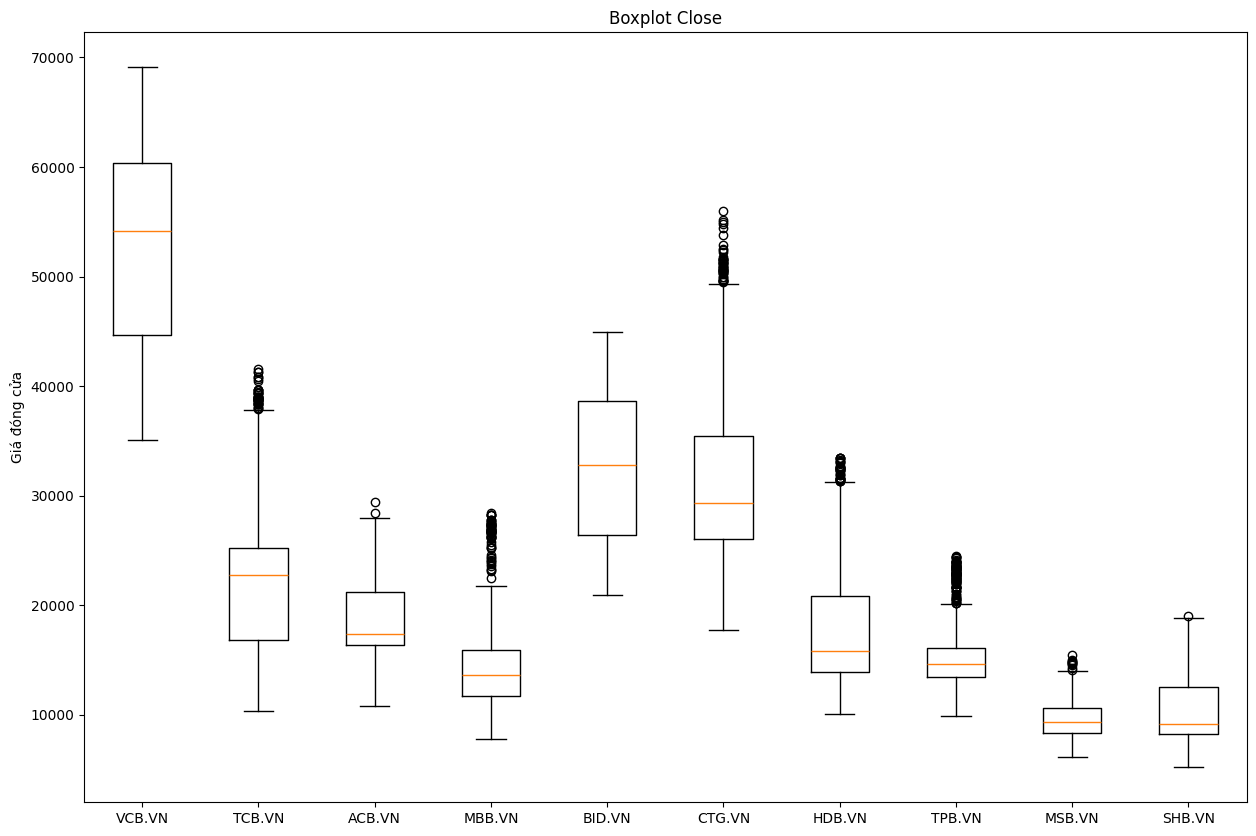

In [ ]:
# Vẽ boxplot cho tất cả ngân hàng VN
plt.figure(figsize=(15, 10))
plt.boxplot([data[data['Ngan_hang_VN'] == ticker]['Close'] for ticker in ngan_hang_vn], labels=ngan_hang_vn)
plt.title('Boxplot Close')
plt.ylabel('Giá đóng cửa')
plt.show()

# Handling Outliers

In [ ]:
# Xử lý outliers bằng tứ phân vị
def handle_outliers(data, column, lower_quantile=0.05, upper_quantile=0.95):
    """
    Xử lý outliers trong một cột của DataFrame sử dụng phương pháp tứ phân vị (quantile).

    Args:
        data (pd.DataFrame): DataFrame chứa dữ liệu.
        column (str): Tên cột cần xử lý outliers.
        lower_quantile (float): Ngưỡng tứ phân vị dưới (mặc định 0.05).
        upper_quantile (float): Ngưỡng tứ phân vị trên (mặc định 0.95).

    Returns:
        pd.DataFrame: DataFrame mới với outliers được thay thế bằng giá trị biên.
    """
    Q1 = data[column].quantile(lower_quantile)
    Q3 = data[column].quantile(upper_quantile)
    # IQR = Q3 - Q1

    # Xác định giới hạn dưới và trên
    # lower_bound = Q1 - 1.5 * IQR
    # upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1
    upper_bound = Q3

    # Thay thế outliers bằng giá trị biên
    data_cleaned = data.copy()
    data_cleaned[column] = np.where(data_cleaned[column] < lower_bound, lower_bound, data_cleaned[column])
    data_cleaned[column] = np.where(data_cleaned[column] > upper_bound, upper_bound, data_cleaned[column])

    return data_cleaned

In [ ]:
data = handle_outliers(data, 'Close')

# Apply Regression to Analyze

In [ ]:
# Apply Regression to Analyze
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Chọn các feature (X) và target (y)
# Sử dụng các cột 'Open', 'High', 'Low', 'Volume' để dự đoán 'Close'
features = ['Open', 'High', 'Low', 'Volume']
target = 'Close'

# Đảm bảo các cột cần thiết có trong DataFrame
if all(col in data_final.columns for col in features + [target]):
    X = data_final[features]
    y = data_final[target]

    # Chia dữ liệu thành tập huấn luyện và tập kiểm tra
    # Sử dụng train_test_split với test_size = 20%
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Khởi tạo và huấn luyện mô hình Hồi quy Tuyến tính
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Dự đoán trên tập kiểm tra
    y_pred = model.predict(X_test)

    # Đánh giá mô hình
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("--- KẾT QUẢ HỒI QUY TUYẾN TÍNH ---")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"R-squared (R2): {r2:.2f}")

    # Hiển thị các hệ số của mô hình
    print("\nHệ số hồi quy:")
    for feature, coef in zip(features, model.coef_):
        print(f"{feature}: {coef:.4f}")
    print(f"Intercept: {model.intercept_:.4f}")

else:
    print("Không đủ các cột cần thiết ('Open', 'High', 'Low', 'Volume', 'Close') trong DataFrame.")

--- KẾT QUẢ HỒI QUY TUYẾN TÍNH ---
Mean Squared Error (MSE): 43695.11
R-squared (R2): 1.00

Hệ số hồi quy:
Open: -0.4563
High: 0.7254
Low: 0.7298
Volume: -0.0000
Intercept: 22.7082


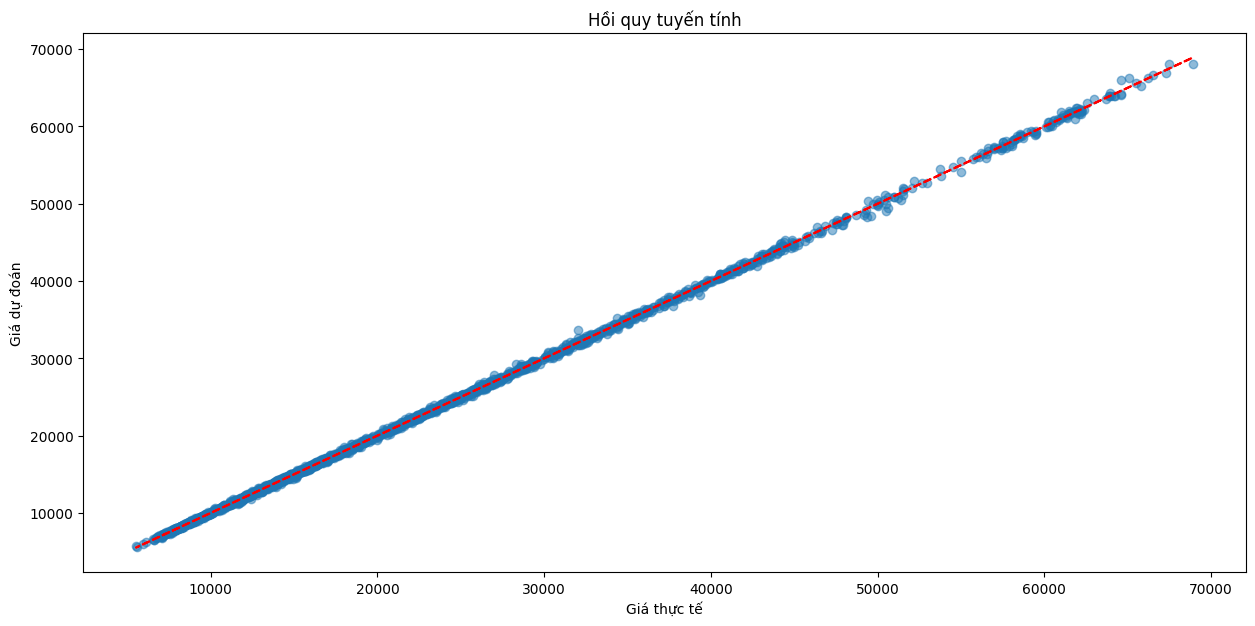

In [ ]:
# Vẽ đường hồi quy
plt.figure(figsize=(15, 7))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot(y_test, y_test, color='red', linestyle='--')
plt.xlabel('Giá thực tế')
plt.ylabel('Giá dự đoán')
plt.title('Hồi quy tuyến tính')
plt.show()